In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [98]:
np.random.seed(42)

# Pricing Bermudan (American-ish) Options via Least–Squares Monte Carlo

This document describes in detail how to implement the **Longstaff–Schwartz** (2001) algorithm for pricing a Bermudan option (a discretely exercisable American option) using Python. We will:

---

## 1. Problem Setup

- We have exercise dates  
  $$
    0 = t_0 < t_1 < t_2 < \cdots < t_N = T\,.
  $$
- On each date $t_i$ the (undiscounted) payoff of immediate exercise is  
  $$
    F_{t_i} = h\bigl(S_{t_i}\bigr),
  $$
  e.g.\ for a put option $h(S) = \max(K - S,0)$.
- We work under the risk-neutral measure $\mathbb{Q}$. Let  
  $$
    D_{t_i,t_j} = \exp\bigl(-\!\int_{t_i}^{t_j} r(s)\,ds \bigr)
  $$
  be the stochastic discount factor.

The continuation value at time $t_i$ is
$$
  C_{t_i} \;=\;
  \mathbb{E}^\mathbb{Q}\bigl[D_{t_i,t_{i+1}}\,V_{t_{i+1}}\mid \mathcal{F}_{t_i}\bigr],
$$
(note that we wish to find a good regression for the estimate of this continuation value) where
$$
  V_{t_{i+1}} \;=\; \max\bigl(F_{t_{i+1}},\,C_{t_{i+1}}\bigr).
$$
The Longstaff–Schwartz algorithm replaces this conditional expectation by a least-squares regression on simulated paths.

---

## 2. Longstaff–Schwartz Algorithm (Backward Induction)

1. **Simulate** $M$ paths of the underlying price $S_{t_i}^{(m)}$, $i=0,\dots,N$, under $\mathbb{Q}$.  
2. **Initialize** cash-flows at maturity:  
   $$
     X_{t_N}^{(m)} = F_{t_N}^{(m)},\quad m=1,\dots,M.
   $$
3. **Backward induction** for $i = N-1,\,N-2,\,\dots,1$:
   a. For each path $m$, collect the in-the-money subset $\{m : F_{t_i}^{(m)}>0\}$.  
   b. Regress the *discounted* continuation values  
      $$
        Y^{(m)} = D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}
      $$
      against basis functions of the state $S_{t_i}^{(m)}$, e.g.\ polynomials $\{1,\,S,\,S^2\}$.  
   c. Denote the fitted regression by $\widehat C_{t_i}(S)$.  
   d. **Exercise decision**:  
      $$
        X_{t_i}^{(m)}
        =
        \begin{cases}
          F_{t_i}^{(m)}, &\text{if }F_{t_i}^{(m)} \ge \widehat C_{t_i}\bigl(S_{t_i}^{(m)}\bigr),\\[6pt]
          D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}, &\text{otherwise.}
        \end{cases}
      $$
4. **Price** at $t=0$ is estimated by the discounted expectation of $X_{t_1}$:
   $$
     \widehat V_0
     = \frac{1}{M}\sum_{m=1}^M D_{0,t_1}\;X_{t_1}^{(m)}.
   $$

In [99]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=float)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [100]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

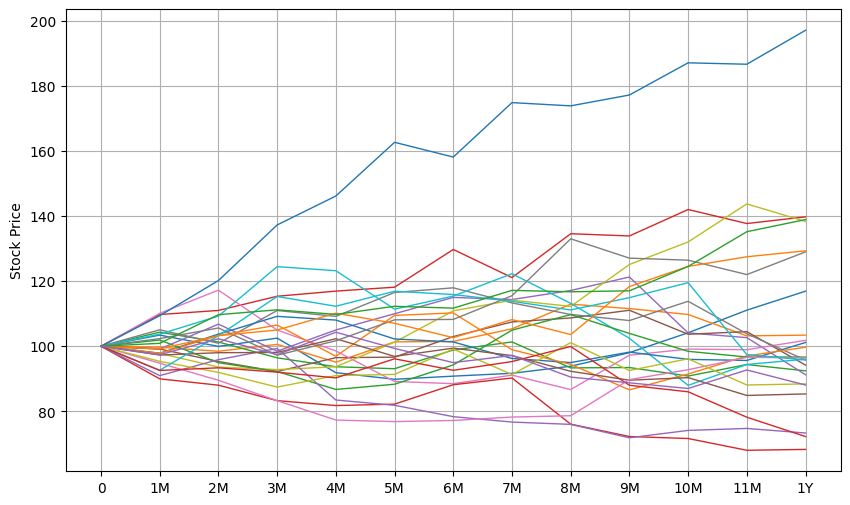

In [101]:
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q) # generates Monte Carlo Paths for the stock price
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts, paths[:, :25], lw=1)
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option

In [102]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

np.float64(4.272565546175375)

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [103]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount

    # THE REGRESSION IS DONE HERE -- here, we are simply using polynomial regression
    # (recall the other methods from ConditionalExpectation.ipynb)
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

np.float64(4.99187668132413)

For your reference, the price of the Bermudan option is $5.152$. In the exercise below, try to see if you can get close to this value (will be helpful for our project later on)

# **Longstaff–Schwartz** Regression Method

We now adapt both the **Longstaff–Schwartz** (LS) algorithm to use three different regression methods:

  1. **Black–Scholes basis**: $\{1,\;P_{\rm BS}(S_{t},K,r,\bar\sigma,\tau)\}$  
     where $P_{\rm BS}$ is the European‐put formula with volatility $\bar\sigma=0.2$ and remaining time $\tau=T-t$.  
  2. **Piecewise‐linear regression** with $J$ knots. (Try different values of $J$)
  3. **Kernel (Nadaraya–Watson)** regression with a Gaussian kernel and bandwidth $h$. (Try different values of $h$).

We first set up our simulation and then define:
- A **Black–Scholes European Pricer** function (GIVEN BELOW),
- (**Task 1**) A **pricers** (`ls_pricer`) that estimates the CONTINUATION VALUE to decide whether or not you will exercise on a certain date.

In [104]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model

    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')

np.float64(1.5342604771222823)

The Longstaff-Schwartz algorithm provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue.

**(Task 2)** Perform an independent Monte Carlo simulation using this estimate of continuation value from LS algorithm as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. Try different methods for regression and compare the results.

Show your code and result with at least 100000 simulations.

# Task 1

In [105]:
# regression: polynomial

def regression_polynomial(X, Y, S_current, degree=3, **kwargs):

    coeffs = np.polyfit(X, Y, deg=degree)
    cont_value = np.polyval(coeffs, S_current)
    model = {
        'type': 'polynomial',
        'coeffs': coeffs,
        'degree': degree
    }

    return cont_value, model

In [106]:
# regression: bs

def regression_bs_basis(X, Y, S_current, K, r, tau, vol=0.2, q=0, **kwargs):
    Z_train = blackscholes_price(K, tau, X, vol, r, q, callput='put')

    A = np.vstack([np.ones(len(Z_train)), Z_train]).T
    beta = np.linalg.lstsq(A, Y, rcond=None)[0]

    Z_current = blackscholes_price(K, tau, S_current, vol, r, q, callput='put')
    cont_value = beta[0] + beta[1] * Z_current

    model = {
        'type': 'bs_basis',
        'beta': beta,
        'vol': vol,
        'q': q,
        'tau': tau
    }

    return cont_value, model

In [107]:
# regression: piecewise

def regression_piecewise(X, Y, S_current, n_knots=10, **kwargs):
    knots = np.percentile(X, np.linspace(0, 100, n_knots+1))

    segment = np.searchsorted(knots, S_current) - 1
    segment = np.clip(segment, 0, n_knots-1)

    cont_value = np.zeros_like(S_current, dtype=float)
    coeffs_list = []

    for i in range(n_knots):
        mask = (X >= knots[i]) & (X < knots[i+1])
        if i == n_knots-1:
            mask = (X >= knots[i]) & (X <= knots[i+1])

        if np.sum(mask) >= 2:
            X_seg = X[mask]
            Y_seg = Y[mask]
            coeffs = np.polyfit(X_seg, Y_seg, deg=1)
            coeffs_list.append(coeffs)

            current_mask = segment == i
            cont_value[current_mask] = np.polyval(coeffs, S_current[current_mask])
        else:
            coeffs_list.append(None)

    model = {
        'type': 'piecewise',
        'knots': knots,
        'coeffs_list': coeffs_list,
        'n_knots': n_knots
    }

    return cont_value, model

In [108]:
# regression: kernel

def regression_kernel(X, Y, S_current, bandwidth=10, **kwargs):
    distances = S_current[:, np.newaxis] - X[np.newaxis, :]

    weights = np.exp(-0.5 * (distances / bandwidth)**2)
    weights /= weights.sum(axis=1, keepdims=True)

    cont_value = weights @ Y

    model = {
        'type': 'kernel',
        'bandwidth': bandwidth,
        'X': X,
        'Y': Y
    }

    return cont_value, model

In [109]:
# ls_pricer

def ls_pricer(paths, K, r, ts, regression_func, **regression_params):
    n_steps, n_paths = paths.shape
    payoff = np.maximum(K - paths[-1], 0)

    exercise_policy = {
        'models': [],
        'ts': ts,
        'K': K,
        'r': r,
        'regression_func': regression_func,
        'regression_params': regression_params
    }

    for i in range(n_steps-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff_discounted = payoff * discount

        exercise_value = np.maximum(K - paths[i], 0)

        X = paths[i]
        Y = payoff_discounted
        tau = ts[-1] - ts[i]

        cont_value, model = regression_func(
            X, Y, X,
            K=K, r=r, tau=tau,
            **regression_params
        )

        exercise_policy['models'].insert(0, model)

        exercise_mask = exercise_value > cont_value

        payoff_new = payoff_discounted.copy()
        payoff_new[exercise_mask] = exercise_value[exercise_mask]
        payoff = payoff_new

    price = np.mean(payoff * np.exp(-r * (ts[1] - ts[0])))

    return price, exercise_policy

In [110]:
np.random.seed(42)
ts = np.linspace(0, T, 13)
paths = blackscholes_mc(ts, 2000, S0, vol, r, q)

In [111]:
# piecewise - tuning

print("="*60)
print("PIECEWISE LINEAR REGRESSION - PARAMETER TUNING")
print("="*60)

results_pw = []
for n_knots in [3, 4, 5, 6, 7, 10, 20, 30, 40, 50]:
    price, _ = ls_pricer(
        paths, K, r, ts,
        regression_func=regression_piecewise,
        n_knots=n_knots
    )
    error = abs(price - 5.152)
    results_pw.append({
        'n_knots': n_knots,
        'Price': price,
        'Error': error
    })
    print(f"n_knots={n_knots:2d}  |  Price: {price:.4f}  |  Error: {error:.4f}")

print(f"\nReference price: 5.152")

PIECEWISE LINEAR REGRESSION - PARAMETER TUNING
n_knots= 3  |  Price: 5.1146  |  Error: 0.0374
n_knots= 4  |  Price: 5.1830  |  Error: 0.0310
n_knots= 5  |  Price: 5.1718  |  Error: 0.0198
n_knots= 6  |  Price: 5.1662  |  Error: 0.0142
n_knots= 7  |  Price: 5.1428  |  Error: 0.0092
n_knots=10  |  Price: 5.1743  |  Error: 0.0223
n_knots=20  |  Price: 5.3352  |  Error: 0.1832
n_knots=30  |  Price: 5.3304  |  Error: 0.1784
n_knots=40  |  Price: 5.4218  |  Error: 0.2698
n_knots=50  |  Price: 5.4961  |  Error: 0.3441

Reference price: 5.152


In [112]:
# krenel - tuning

print("="*60)
print("KERNEL REGRESSION - PARAMETER TUNING")
print("="*60)

results_kr = []
for h in [2, 3, 5, 10, 20, 50]:
    price, _ = ls_pricer(
        paths, K, r, ts,
        regression_func=regression_kernel,
        bandwidth=h
    )
    error = abs(price - 5.152)
    results_kr.append({
        'bandwidth': h,
        'Price': price,
        'Error': error
    })
    print(f"bandwidth={h:2d}  |  Price: {price:.4f}  |  Error: {error:.4f}")

print(f"\nReference price: 5.152")

KERNEL REGRESSION - PARAMETER TUNING
bandwidth= 2  |  Price: 5.1844  |  Error: 0.0324
bandwidth= 3  |  Price: 5.1128  |  Error: 0.0392
bandwidth= 5  |  Price: 5.0450  |  Error: 0.1070
bandwidth=10  |  Price: 4.8211  |  Error: 0.3309
bandwidth=20  |  Price: 4.6537  |  Error: 0.4983
bandwidth=50  |  Price: 4.5879  |  Error: 0.5641

Reference price: 5.152


In [118]:
# result for task1

print("="*60)
print("FINAL COMPARISON WITH OPTIMAL PARAMETERS")
print("="*60)

price_poly, policy_poly = ls_pricer(paths, K, r, ts, regression_polynomial)
price_bs, policy_bs = ls_pricer(paths, K, r, ts, regression_bs_basis, vol=0.2)

best_pw = min(results_pw, key=lambda x: x['Error'])
best_kr = min(results_kr, key=lambda x: x['Error'])

print(f"\nBest parameters found:")
print(f"  Piecewise: n_knots={best_pw['n_knots']} (error: {best_pw['Error']:.4f})")
print(f"  Kernel: bandwidth={best_kr['bandwidth']} (error: {best_kr['Error']:.4f})")

print(f"\nFinal prices with optimal parameters:")
print(f"  Polynomial (deg=3)       : {price_poly:.4f}")
print(f"  BS Basis (vol=0.2)       : {price_bs:.4f}")
print(f"  Piecewise (n_knots={best_pw['n_knots']})    : {best_pw['Price']:.4f}")
print(f"  Kernel (bandwidth={best_kr['bandwidth']})     : {best_kr['Price']:.4f}")

FINAL COMPARISON WITH OPTIMAL PARAMETERS

Best parameters found:
  Piecewise: n_knots=7 (error: 0.0092)
  Kernel: bandwidth=2 (error: 0.0324)

Final prices with optimal parameters:
  Polynomial (deg=3)       : 5.0710
  BS Basis (vol=0.2)       : 5.1727
  Piecewise (n_knots=7)    : 5.1428
  Kernel (bandwidth=2)     : 5.1844


# Task 2

In [114]:
# simulation

def independent_pricing(exercise_policy, n_paths=100000):
    ts = exercise_policy['ts']
    K = exercise_policy['K']
    r = exercise_policy['r']
    regression_func = exercise_policy['regression_func']
    regression_params = exercise_policy['regression_params']
    models = exercise_policy['models']

    new_paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)

    n_steps = len(ts)
    payoff = np.maximum(K - new_paths[-1], 0)

    for i in range(n_steps-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff = payoff * discount

        exercise_value = np.maximum(K - new_paths[i], 0)

        model = models[i-1]

        if model['type'] == 'polynomial':
            cont_value = np.polyval(model['coeffs'], new_paths[i])
        elif model['type'] == 'bs_basis':
          tau = model['tau']
          Z = blackscholes_price(K, tau, new_paths[i], model['vol'], r, model['q'], callput='put')
          cont_value = model['beta'][0] + model['beta'][1] * Z
        elif model['type'] == 'piecewise':
            knots = model['knots']
            coeffs_list = model['coeffs_list']
            n_knots = model['n_knots']
            segment = np.searchsorted(knots, new_paths[i]) - 1
            segment = np.clip(segment, 0, n_knots-1)
            cont_value = np.zeros(n_paths)
            for j in range(n_knots):
                mask = segment == j
                if coeffs_list[j] is not None and np.sum(mask) > 0:
                    cont_value[mask] = np.polyval(coeffs_list[j], new_paths[i][mask])
        elif model['type'] == 'kernel':
            distances = new_paths[i][:, np.newaxis] - model['X'][np.newaxis, :]
            weights = np.exp(-0.5 * (distances / model['bandwidth'])**2)
            weights /= weights.sum(axis=1, keepdims=True)
            cont_value = weights @ model['Y']

        exercise_mask = exercise_value > cont_value
        payoff_new = payoff.copy()
        payoff_new[exercise_mask] = exercise_value[exercise_mask]
        payoff = payoff_new

    price = np.mean(payoff * np.exp(-r * (ts[1] - ts[0])))

    return price

In [119]:
# result for task2

print("="*70)
print("TASK 2: INDEPENDENT MONTE CARLO PRICING (100,000 PATHS)")
print("="*70)
print("\nApplying learned exercise policies to independent simulation paths\n")

print(f"{'Method':<25} {'Task 1':>12} {'Task 2':>12} {'Difference':>12}")
print("-"*70)

# 1. Polynomial
price_task2_poly = independent_pricing(policy_poly, n_paths=100000)
diff_poly = price_poly - price_task2_poly
print(f"{'Polynomial (deg=3)':<25} {price_poly:>12.4f} {price_task2_poly:>12.4f} {diff_poly:>12.4f}")

# 2. BS Basis
price_task2_bs = independent_pricing(policy_bs, n_paths=100000)
diff_bs = price_bs - price_task2_bs
print(f"{'BS Basis (vol=0.2)':<25} {price_bs:>12.4f} {price_task2_bs:>12.4f} {diff_bs:>12.4f}")

# 3. Piecewise
_, policy_pw_final = ls_pricer(paths, K, r, ts, regression_piecewise, n_knots=best_pw['n_knots'])
price_task2_pw = independent_pricing(policy_pw_final, n_paths=100000)
diff_pw = best_pw['Price'] - price_task2_pw
print(f"{'Piecewise (n_knots=' + str(best_pw['n_knots']) + ')':<25} {best_pw['Price']:>12.4f} {price_task2_pw:>12.4f} {diff_pw:>12.4f}")

# 4. Kernel
_, policy_kr_final = ls_pricer(paths, K, r, ts, regression_kernel, bandwidth=best_kr['bandwidth'])
price_task2_kr = independent_pricing(policy_kr_final, n_paths=100000)
diff_kr = best_kr['Price'] - price_task2_kr
print(f"{'Kernel (bandwidth=' + str(best_kr['bandwidth']) + ')':<25} {best_kr['Price']:>12.4f} {price_task2_kr:>12.4f} {diff_kr:>12.4f}")

print("="*70)



TASK 2: INDEPENDENT MONTE CARLO PRICING (100,000 PATHS)

Applying learned exercise policies to independent simulation paths

Method                          Task 1       Task 2   Difference
----------------------------------------------------------------------
Polynomial (deg=3)              5.0710       5.0441       0.0269
BS Basis (vol=0.2)              5.1727       5.1681       0.0046
Piecewise (n_knots=7)           5.1428       5.0992       0.0436
Kernel (bandwidth=2)            5.1844       5.1324       0.0520


## Why Task 2 Provides a Lower Bound

### Theoretical Foundation:

The Longstaff-Schwartz algorithm learns an approximate exercise policy from a finite training sample. Task 2 estimates provide a lower bound due to the fundamental distinction between in-sample and out-of-sample evaluation.

**Training Bias (Task 1):**
The exercise policy is learned by optimizing on the training paths. When we evaluate this policy on the same paths used for training, we obtain an overly optimistic estimate. This is analogous to overfitting in machine learning: the policy is tailored to the specific training sample, resulting in inflated performance metrics.

**Unbiased Evaluation (Task 2):**
Task 2 applies the learned policy to independent test paths that were not used during training. Since these paths are statistically independent from the training data, the evaluation is unbiased. The policy cannot exploit the specific characteristics of these new paths, yielding a realistic assessment of its true performance.

**Key Inequality:**
The expected in-sample estimate (Task 1) is greater than or equal to the true value of the learned policy, which equals the expected out-of-sample estimate (Task 2). This relationship holds because:
1. In-sample evaluation suffers from positive bias due to optimization on the same data
2. Out-of-sample evaluation on independent data provides an unbiased estimate
3. Therefore, in-sample estimates systematically exceed out-of-sample estimates

### Empirical Confirmation:

Our results demonstrate Task 2 ≤ Task 1 consistently across all four regression methods, confirming the theoretical prediction that out-of-sample evaluation provides lower (and more realistic) price estimates than in-sample evaluation.